In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-olympiad-good-health-and-well-being/sample_submission.csv
/kaggle/input/ml-olympiad-good-health-and-well-being/train.csv
/kaggle/input/ml-olympiad-good-health-and-well-being/test.csv


In [2]:
from matplotlib import pyplot as plt
from statistics import mean, median, mode, stdev
import math
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

In [3]:
df_sub = pd.read_csv('/kaggle/input/ml-olympiad-good-health-and-well-being/sample_submission.csv')
df_train = pd.read_csv('/kaggle/input/ml-olympiad-good-health-and-well-being/train.csv')
df_test = pd.read_csv('/kaggle/input/ml-olympiad-good-health-and-well-being/test.csv')

In [4]:
df_train.head()

,PatientID,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,target
0,42351,1,1,1,29,0,0,0,1,1,...,0,3,0,0,0,0,13,5,8,0
1,135091,1,0,1,30,0,1,2,0,0,...,0,2,0,0,0,0,9,5,6,0
2,201403,0,0,1,31,0,0,0,1,1,...,0,2,0,7,0,0,10,6,8,0
3,72750,0,0,1,36,0,0,2,0,0,...,0,2,0,0,0,0,11,5,6,0
4,133895,0,1,1,29,0,0,0,1,1,...,0,4,0,0,1,1,10,6,7,0


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177576 entries, 0 to 177575
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   PatientID          177576 non-null  int64
 1   HighBP             177576 non-null  int64
 2   HighChol           177576 non-null  int64
 3   CholCheck          177576 non-null  int64
 4   BMI                177576 non-null  int64
 5   Smoker             177576 non-null  int64
 6   Stroke             177576 non-null  int64
 7   Diabetes           177576 non-null  int64
 8   PhysActivity       177576 non-null  int64
 9   Fruits             177576 non-null  int64
 10  Veggies            177576 non-null  int64
 11  HvyAlcoholConsump  177576 non-null  int64
 12  AnyHealthcare      177576 non-null  int64
 13  NoDocbcCost        177576 non-null  int64
 14  GenHlth            177576 non-null  int64
 15  MentHlth           177576 non-null  int64
 16  PhysHlth           177576 non-null  in

In [6]:
df_train.target.value_counts()

0    160851
1     16725
Name: target, dtype: int64

In [7]:
df_train.Diabetes.unique()

array([0, 2, 1])

In [8]:
df_train.Education.unique()

array([5, 6, 4, 3, 2, 1])

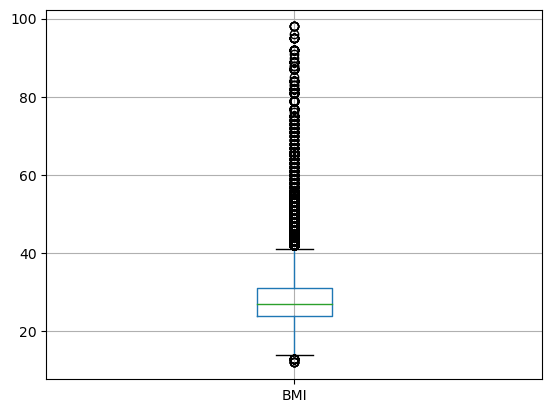

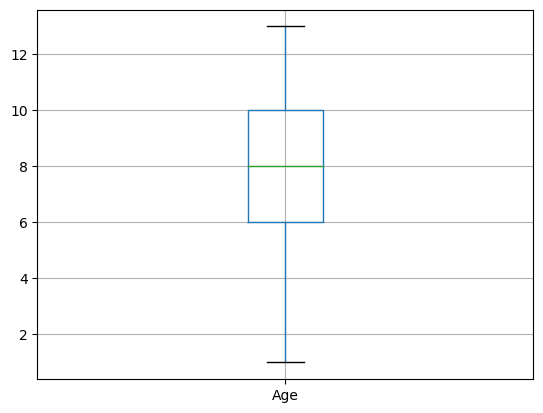

In [9]:
search_outliers = ['BMI','Age']
for column in search_outliers:
    df_train.boxplot(column)
    plt.show()

In [10]:
def chauvenet_filter(value, col_mean, col_stdev, to_cmp):
    return math.erfc(abs(value - col_mean) / col_stdev) < to_cmp

In [11]:
print(len(df_train.index))
col_mean = mean(df_train['BMI'])
col_stdev = stdev(df_train['BMI'])
to_cmp = 1 / (2 * len(df_train['BMI'].index))
outliers = df_train[(df_train['BMI'].apply(lambda value: chauvenet_filter(value, col_mean, col_stdev, to_cmp)))]
df_train.drop(labels=outliers.index, axis=0, inplace=True)
print(len(df_train.index))

177576
176090


In [12]:
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm')

,PatientID,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,target
PatientID,1.000000,0.001456,-0.004413,-0.005782,0.014618,-0.013012,-0.003018,-0.000276,-0.014080,-0.009620,-0.001542,-0.005544,0.000677,0.005420,0.011797,0.004768,0.002351,0.006710,0.002054,-0.017415,-0.028399,-0.031447,0.004507
HighBP,0.001456,1.000000,0.299529,0.100123,0.232084,0.098054,0.129146,0.270145,-0.122100,-0.039199,-0.060900,-0.001284,0.038860,0.016373,0.300085,0.054505,0.159024,0.220844,0.054263,0.345611,-0.143425,-0.170885,0.209992
HighChol,-0.004413,0.299529,1.000000,0.087075,0.123024,0.092213,0.093861,0.209550,-0.078027,-0.041238,-0.040356,-0.011348,0.041426,0.011577,0.210554,0.060621,0.121999,0.145432,0.032187,0.273228,-0.071232,-0.086110,0.181916
CholCheck,-0.005782,0.100123,0.087075,1.000000,0.039293,-0.009819,0.024555,0.067604,0.003629,0.025003,0.006031,-0.026140,0.120245,-0.057710,0.047945,-0.009352,0.032502,0.040798,-0.021285,0.091539,0.001529,0.014712,0.044850
BMI,0.014618,0.232084,0.123024,0.039293,1.000000,0.017254,0.021705,0.240339,-0.148175,-0.090579,-0.066153,-0.049543,-0.016004,0.058495,0.248989,0.080799,0.115006,0.192940,0.057853,-0.022277,-0.113638,-0.097431,0.057695
Smoker,-0.013012,0.098054,0.092213,-0.009819,0.017254,1.000000,0.060916,0.064752,-0.088445,-0.078542,-0.031760,0.101105,-0.023899,0.047225,0.165337,0.090179,0.116460,0.123230,0.095675,0.121500,-0.162398,-0.125037,0.115120
Stroke,-0.003018,0.129146,0.093861,0.024555,0.021705,0.060916,1.000000,0.106911,-0.068127,-0.013306,-0.042804,-0.015377,0.007552,0.037048,0.177047,0.069718,0.149488,0.173721,0.005636,0.124510,-0.074451,-0.127048,0.200918
Diabetes,-0.000276,0.270145,0.209550,0.067604,0.240339,0.064752,0.106911,1.000000,-0.119018,-0.040768,-0.058149,-0.057283,0.014885,0.035055,0.302176,0.073359,0.175028,0.221011,0.032667,0.185645,-0.131191,-0.171926,0.181960
PhysActivity,-0.014080,-0.122100,-0.078027,0.003629,-0.148175,-0.088445,-0.068127,-0.119018,1.000000,0.142096,0.153284,0.013412,0.036036,-0.058903,-0.263698,-0.121298,-0.217331,-0.250780,0.030256,-0.092736,0.200902,0.198533,-0.084493
Fruits,-0.009620,-0.039199,-0.041238,0.025003,-0.090579,-0.078542,-0.013306,-0.040768,0.142096,1.000000,0.255127,-0.034650,0.031799,-0.044481,-0.104039,-0.065208,-0.045496,-0.047990,-0.093470,0.064888,0.110493,0.080138,-0.020449


In [13]:
y_column = 'target'
x_columns = [column for column in df_train.columns if column != 'PatientID' and column != 'target']
X_train = df_train[x_columns]
Y_train = df_train[y_column]
X_test = df_test[x_columns]

In [14]:
feature_ratio = 10/len(x_columns)
selector = SequentialFeatureSelector(
    estimator=LinearRegression(),
    scoring=None,
    n_features_to_select=feature_ratio,
    direction="forward").fit(X=X_train, y=Y_train)
selected_features = selector.get_feature_names_out()
print(f"Выбранные признаки: {', '.join(selected_features)}")

Выбранные признаки: HighBP, HighChol, BMI, Smoker, Stroke, Diabetes, GenHlth, DiffWalk, Sex, Age


In [15]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [16]:
scaler = StandardScaler()
X_train['BMI'] = scaler.fit_transform(X_train[['BMI']])
X_train['Age'] = scaler.fit_transform(X_train[['Age']])
X_test['BMI'] = scaler.fit_transform(X_test[['BMI']])
X_test['Age'] = scaler.fit_transform(X_test[['Age']])

In [17]:
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train, Y_train)

LogisticRegression()

In [18]:
predict = logreg_clf.predict(X_test)

In [19]:
output = pd.DataFrame({'PatientID': df_test.PatientID, 'target': predict})
output.to_csv('submission.csv', index=False)